<a href="https://colab.research.google.com/github/lmmlima/ENV716_EnergyModeling_F2021/blob/main/Lab10/Lab10_ShortestPath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 10 - Network Models: Shortest Path**


Learning goals for Lab9:
* Explore another type of network model, the **shortest path**;
* Learn how to handle **sparse sets** in Pyomo;
* Learn how to define **abstract models**;
Learn how to create and solve an **instance** of an abstratc model.

## Initializing 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

Installing Pyomo and solver. Recall for teh shortest path example we have binary variables so we will need to use another solver. Instead of installing glpk, thsi time we will install COIN-OR CBC. \\ 
COIN-OR CBC is a multi-threaded open-source Coin-or branch and cut **mixed-integer linear programming solver**. CBC is generally a good choice for a general purpose MILP solver for medium to large scale problems.

In [ ]:
!pip install pyomo
#!apt-get install -y -qq glpk-utils
!apt-get install -y -qq coinor-cbc

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/comm

Importing pyomo and cbc solver.

In [ ]:
from pyomo.environ import *
#Import solver
opt=SolverFactory('cbc',executable='/usr/bin/cbc')

## Model 1: Shortest Path

Recall the model you develop in class where you had to find the shortest path from **node 1** to **node 7**. The distances are represented in the graph below.

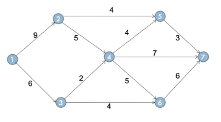

Problem formulation

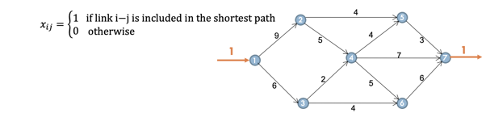

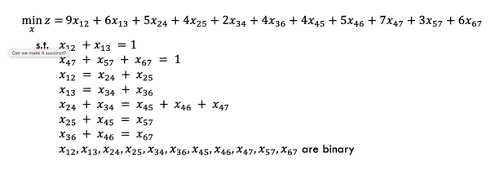

In [ ]:
#Shortest Path - Approach 1
model=ConcreteModel()

model.Arcs=Set(initialize=['(1,2)','(1,3)','(2,4)','(2,5)',
                           '(3,4)','(3,6)','(4,5)','(4,6)',
                           '(4,7)','(5,7)','(6,7)'])

#Add parameter
model.distance=Param(model.Arcs,initialize={
    '(1,2)':9,
    '(1,3)':6,
    '(2,4)':5,
    '(2,5)':4,
    '(3,4)':2,
    '(3,6)':4,
    '(4,5)':4,
    '(4,6)':5,
    '(4,7)':7,
    '(5,7)':3,
    '(6,7)':6})

#Add dec variables
model.X=Var(model.Arcs,domain=Boolean)

#Adding objective function
def min_path(model):
    return sum(model.distance[a]*model.X[a] for a in model.Arcs)
model.shortest=Objective(rule=min_path, sense=minimize)

#Adding constraints
model.orig=Constraint(expr = model.X['(1,2)']+model.X['(1,3)'] == 1)
model.dest=Constraint(expr = model.X['(4,7)']+model.X['(5,7)']+model.X['(6,7)'] == 1)
model.trans2=Constraint(expr = model.X['(1,2)']-model.X['(2,4)']-model.X['(2,5)'] == 0)
model.trans3=Constraint(expr = model.X['(1,3)']-model.X['(3,4)']-model.X['(3,6)'] == 0)
model.trans4=Constraint(expr = model.X['(2,4)']+model.X['(3,4)']-model.X['(4,5)']-model.X['(4,6)']-model.X['(4,7)'] == 0)
model.trans5=Constraint(expr = model.X['(2,5)']+model.X['(4,5)']-model.X['(5,7)'] == 0)
model.trans6=Constraint(expr = model.X['(3,6)']+model.X['(4,6)']-model.X['(6,7)'] == 0)


In [ ]:
#Solve model
opt.solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 15.0, 'Upper bound': 15.0, 'Number of objectives': 1, 'Number of constraints': 3, 'Number of variables': 7, 'Number of binary variables': 11, 'Number of integer variables': 11, 'Number of nonzeros': 7, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.0, 'Wallclock time': 0.0, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 0}}, 'Error rc': 0, 'Time': 0.02019214630126953}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [ ]:
#Print results
print("Min Dist =",model.shortest())
print("Decision Variables")
for a in model.Arcs:
    print(model.X[a],model.X[a].value)

Min Dist = 15.0
Decision Variables
X['(1,2)'] 0.0
X['(1,3)'] 1.0
X['(2,4)'] 0.0
X['(2,5)'] 0.0
X['(3,4)'] 1.0
X['(3,6)'] 0.0
X['(4,5)'] 1.0
X['(4,6)'] 0.0
X['(4,7)'] 0.0
X['(5,7)'] 1.0
X['(6,7)'] 0.0


### Exercise: Can you generalize this model for any network? 

Start by trying to write the MILP model as a fucntion os nodes and arcs. How many sets and parameters you need to represent the network? How can you relate the arcs and nodes?

**Your answer**

## Model 2: Implementing shortest path in its general form

The challenge here is that we use nodes to designates arcs. We haven't learned why to relate the arcs and nodes within the Pyomo environment.  \\

Sets may be created by storing the result of set operations using other Pyomo sets. Pyomo supports set operations including cross-product. The cross-product operator is the asterisk (*). To define a new set M that is the cross product of sets B and C, one could use this notation: \\
$model.M = model.B * model.C$ \\
This creates a virtual set that holds references to the original sets. Let's apply this to our network model.

In [ ]:
from math import inf 
model2=ConcreteModel()

model2.Nodes=Set(initialize=range(1,8))  #['1','2','3','4','5','6','7']
model2.Arcs=Set(initialize=model2.Nodes*model2.Nodes)

model2.Arcs.pprint()

Arcs : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     2 :    Any :   49 : {(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)}


Note that we were able to define arcs as a function of the nodes. But we initialized all possible combinations of nodes, i.e., 49 arcs. Recall we only have 11 arcs. \\

When we index parameters and variables by the set of arcs we will need to assign values for all possible 49 combinations. See below how we would define the parameter distance for all 49 arcs. \\

For applications where all nodes are always connected to all other nodes this would be fine. However, issues can arise when the network is not fully dense. The shortest path problem is an example of an optimization model that has a **sparse set**. For example, the burden of avoiding flow on arcs that do not exist falls on providing high-enough costs for those arcs. Such a scheme is not very elegant or robust.

In [ ]:
#Add parameter
model2.distance=Param(model2.Arcs,initialize={
    (1,1):+inf,
    (1,2):9,
    (1,3):6,
    (1,4):+inf,
    (1,5):+inf,
    (1,6):+inf,
    (1,7):+inf,
    (2,1):+inf,
    (2,2):+inf,
    (2,3):+inf,
    (2,4):5,
    (2,5):4,
    (2,6):+inf,
    (2,7):+inf,
    (3,1):+inf,
    (3,2):+inf,
    (3,3):+inf,
    (3,4):2,
    (3,5):+inf,
    (3,6):4,
    (3,7):+inf,
    (4,1):+inf,
    (4,2):+inf,
    (4,3):+inf,
    (4,4):+inf,
    (4,5):4,
    (4,6):5,
    (4,7):7,
    (5,1):+inf,
    (5,2):+inf,
    (5,3):+inf,
    (5,4):+inf,
    (5,5):+inf,
    (5,6):+inf,
    (5,7):3,
    (6,1):+inf,
    (6,2):+inf,
    (6,3):+inf,
    (6,4):+inf,
    (6,5):+inf,
    (6,6):+inf,
    (6,7):6,
    (7,1):+inf,
    (7,2):+inf,
    (7,3):+inf,
    (7,4):+inf,
    (7,5):+inf,
    (7,6):+inf,
    (7,7):+inf })
model2.distance.pprint()

    'pyomo.core.base.param.IndexedParam'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.param.IndexedParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
distance : Size=49, Index=Arcs, Domain=Any, Default=None, Mutable=False
    Key    : Value
    (1, 1) :   inf
    (1, 2) :     9
    (1, 3) :     6
    (1, 4) :   inf
    (1, 5) :   inf
    (1, 6) :   inf
    (1, 7) :   inf
    (2, 1) :   inf
    (2, 2) :   inf
    (2, 3) :   inf
    (2, 4) :     5
    (2, 5) :     4
    (2, 6) :   inf
    (2, 7) :   inf
    (3, 1) :   inf
    (3, 2) :   inf
    (3, 3) :   inf
    (3, 4) :     2
    (3, 5) :   inf
    (3, 6) :     4
    (3, 7) :   inf
    (4, 1) :   inf
    (4, 2) :   inf
    (4, 3) :   inf
    (4, 4) :   inf
    (4, 5) :     4
    (4, 6) :     5
    (4, 7) :     7
    (5, 1) :   inf
    (5, 2) :   inf
    (5, 3) :   inf
    (5, 4) :   inf
    (5, 5) :   inf
    (5, 6) 

The Set object in Pyomo has an argument we haven't used yet called **within**. If we replace *initialize* with *within* when defining the set of arcs we would overcome this issue of sparse sets.

In [ ]:
model2=ConcreteModel()

model2.Nodes=Set(initialize=range(1,8))  #['1','2','3','4','5','6','7']
model2.Arcs=Set(within=model2.Nodes*model2.Nodes)

model2.Arcs.pprint()

Arcs : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain      : Size : Members
    None :     2 : Arcs_domain :    0 :      {}


We just created the set of arc but we did not specify any arcs. If we want to create the arcs we need to add argument initialize.

In [ ]:
model2=ConcreteModel()

model2.Nodes=Set(initialize=range(1,8))  #['1','2','3','4','5','6','7']
model2.Arcs=Set(within=model2.Nodes*model2.Nodes, initialize=[(1,2),(1,3),(2,4),(2,5),(3,4),(3,6),(4,5),(4,6),(4,7),(5,7),(6,7)])

model2.Arcs.pprint()

Arcs : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain      : Size : Members
    None :     2 : Arcs_domain :   11 : {(1, 2), (1, 3), (2, 4), (2, 5), (3, 4), (3, 6), (4, 5), (4, 6), (4, 7), (5, 7), (6, 7)}


Now when we define distance we can provide scalars just for the arcs we initialized.

In [ ]:
#Add parameter
model2.distance=Param(model2.Arcs,initialize={
    (1,2):9,
    (1,3):6,
    (2,4):5,
    (2,5):4,
    (3,4):2,
    (3,6):4,
    (4,5):4,
    (4,6):5,
    (4,7):7,
    (5,7):3,
    (6,7):6})

Now we proceed with decision variables, objective and contraints. 

### Exercise: Try to declare this components.

In [ ]:
#Add dec variables
#arc being used or not - decision variable xij

##YOUR CODE


    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


In [ ]:
#Adding objective function
def min_path(model2):
    return ##YOUR CODE
model2.shortest=Objective(rule=min_path, sense=minimize)

print(model2.shortest.expr)


    'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
9*x[1,2] + 6*x[1,3] + 5*x[2,4] + 4*x[2,5] + 2*x[3,4] + 4*x[3,6] + 4*x[4,5] + 5*x[4,6] + 7*x[4,7] + 3*x[5,7] + 6*x[6,7]


In [ ]:
#Adding constraints
def flow_rule(model2, n):
   ##YOUR CODE
model2.flow = Constraint(model2.Nodes, rule=flow_rule)

for i in model2.Nodes:
  print(model2.flow[i].expr)


    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
x[1,2] + x[1,3]  ==  1
x[1,2]  ==  x[2,4] + x[2,5]
x[1,3]  ==  x[3,4] + x[3,6]
x[2,4] + x[3,4]  ==  x[4,5] + x[4,6] + x[4,7]
x[2,5] + x[4,5]  ==  x[5,7]
x[3,6] + x[4,6]  ==  x[6,7]
x[4,7] + x[5,7] + x[6,7]  ==  1


In [ ]:
opt.solve(model2)

#Print results
print("Min Dist =",model2.shortest())
print("Decision Variables")
for a in model2.Arcs:
    print(model2.x[a],model2.x[a].value)

Min Dist = 15.0
Decision Variables
x[1,2] 0.0
x[1,3] 1.0
x[2,4] 0.0
x[2,5] 0.0
x[3,4] 1.0
x[3,6] 0.0
x[4,5] 1.0
x[4,6] 0.0
x[4,7] 0.0
x[5,7] 1.0
x[6,7] 0.0


## Model 3: Shortest Path using Abstract Model

Now that we are begining to create more general models we will learn how to work with abstract models. The excercise we did before where we tried to generalize the model was a preparation for understanding **abstract models**. \\
Abstract models are just defined by symbols and rules. You can not use the argument expr when defining constraints and objetive for abstract models.

The idea is to create a general model that would be used to solve multiple **instances** fo the same optimization problem. In other words we could solve the same problem for different parameters.
 

In [ ]:
#Shortest Path - Approach 2 - Abstract Model
model2 = AbstractModel()

model2.N = Set() #Nodes set
model2.A = Set(within=model2.N*model2.N) #Arcs set #note we use Sparse Index Sets

model2.distance = Param(model2.A, within=PositiveReals)    

# arc being used or not - decision variable xij
model2.x = Var(model2.A,within=Boolean)

#Find shortest path
def dist_rule(model2):
    return sum(model2.distance[i,j]*model2.x[i,j] for (i,j) in model2.A)
model2.shortest = Objective(rule=dist_rule, sense=minimize)

# Flow constraint
def flow_rule(model2, n):
    if(n == model2.N.first()): #origin constraint
        return sum(model2.x[i,j] for (i,j) in model2.A if i==n) == 1
    elif(n == model2.N.last()):  #destination constraint
        return sum(model2.x[i,j] for (i,j) in model2.A if j==n) == 1
    else: #transhipment constraint
        inFlow  = sum(model2.x[i,j] for (i,j) in model2.A if j == n)
        outFlow = sum(model2.x[j,i] for (j,i) in model2.A if j == n)
        return inFlow == outFlow
model2.flow = Constraint(model2.N, rule=flow_rule)


Now the model is defined. And we can feed parameters to the model. This process is called creating an instance. The model parameters can be manually input after the model definition or you can import parameters from a text file. That's the preferred method. Check the file "short_path_ex.dat" to check the structure of the file. When creating an instance you can use a .txt file, but to load the instance you need to change extension to .dat. 

In [ ]:
#Load data and create instance
instance=model2.create_instance('short_path_ex.dat')
instance.pprint()


3 Set Declarations
    A : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain   : Size : Members
        None :     2 : A_domain :   11 : {('N1', 'N2'), ('N1', 'N3'), ('N2', 'N4'), ('N2', 'N5'), ('N3', 'N4'), ('N3', 'N6'), ('N4', 'N5'), ('N4', 'N6'), ('N4', 'N7'), ('N5', 'N7'), ('N6', 'N7')}
    A_domain : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    N*N :   49 : {('N1', 'N1'), ('N1', 'N2'), ('N1', 'N3'), ('N1', 'N4'), ('N1', 'N5'), ('N1', 'N6'), ('N1', 'N7'), ('N2', 'N1'), ('N2', 'N2'), ('N2', 'N3'), ('N2', 'N4'), ('N2', 'N5'), ('N2', 'N6'), ('N2', 'N7'), ('N3', 'N1'), ('N3', 'N2'), ('N3', 'N3'), ('N3', 'N4'), ('N3', 'N5'), ('N3', 'N6'), ('N3', 'N7'), ('N4', 'N1'), ('N4', 'N2'), ('N4', 'N3'), ('N4', 'N4'), ('N4', 'N5'), ('N4', 'N6'), ('N4', 'N7'), ('N5', 'N1'), ('N5', 'N2'), ('N5', 'N3'), ('N5', 'N4'), ('N5', 'N5'), ('N5', 'N6'), ('N5', 'N7'), ('N6', 'N1'), ('N6', 'N2'), ('N6', 'N3'), ('N6', 'N4'), ('N6', 'N

Now our instance has been created. Note that when printing the model we refer to instance and not model. Same is true when solving it.

In [ ]:
opt.solve(instance)

#Print results
print("Min Dist =",instance.shortest())
print("Decision Variables")
for (i,j) in instance.A:
    print(instance.x[i,j],instance.x[i,j].value)

Min Dist = 15.0
Decision Variables
x[N1,N2] 0.0
x[N1,N3] 1.0
x[N2,N4] 0.0
x[N2,N5] 0.0
x[N3,N4] 1.0
x[N3,N6] 0.0
x[N4,N5] 1.0
x[N4,N6] 0.0
x[N4,N7] 0.0
x[N5,N7] 1.0
x[N6,N7] 0.0


If you need to make changes to the nodes distance or even to the network you can create a new dat file, change information there, and create a another instance. 

### Exercise: Create another instance

As an example note the file "short_path_ex2.dat" where we change the distance from node 1 to 3 to 60. Create a new instance to represent that new network, solve it and compare with the solution we had before.

In [ ]:
#Load data from short_path_ex2.dat and create instance

##YOUR CODE

3 Set Declarations
    A : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain   : Size : Members
        None :     2 : A_domain :   11 : {('N1', 'N2'), ('N1', 'N3'), ('N2', 'N4'), ('N2', 'N5'), ('N3', 'N4'), ('N3', 'N6'), ('N4', 'N5'), ('N4', 'N6'), ('N4', 'N7'), ('N5', 'N7'), ('N6', 'N7')}
    A_domain : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    N*N :   49 : {('N1', 'N1'), ('N1', 'N2'), ('N1', 'N3'), ('N1', 'N4'), ('N1', 'N5'), ('N1', 'N6'), ('N1', 'N7'), ('N2', 'N1'), ('N2', 'N2'), ('N2', 'N3'), ('N2', 'N4'), ('N2', 'N5'), ('N2', 'N6'), ('N2', 'N7'), ('N3', 'N1'), ('N3', 'N2'), ('N3', 'N3'), ('N3', 'N4'), ('N3', 'N5'), ('N3', 'N6'), ('N3', 'N7'), ('N4', 'N1'), ('N4', 'N2'), ('N4', 'N3'), ('N4', 'N4'), ('N4', 'N5'), ('N4', 'N6'), ('N4', 'N7'), ('N5', 'N1'), ('N5', 'N2'), ('N5', 'N3'), ('N5', 'N4'), ('N5', 'N5'), ('N5', 'N6'), ('N5', 'N7'), ('N6', 'N1'), ('N6', 'N2'), ('N6', 'N3'), ('N6', 'N4'), ('N6', 'N

In [ ]:
opt.solve(##YOUR CODE)

#Print results

##YOUR CODE

Min Dist = 16.0
Decision Variables
x[N1,N2] 1.0
x[N1,N3] 0.0
x[N2,N4] 0.0
x[N2,N5] 1.0
x[N3,N4] 0.0
x[N3,N6] 0.0
x[N4,N5] 0.0
x[N4,N6] 0.0
x[N4,N7] 0.0
x[N5,N7] 1.0
x[N6,N7] 0.0
